<a href="https://colab.research.google.com/github/fambargh/SAMPLE/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [2]:
#load libraries which are necessary
from google.colab import files
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers.core import Activation
from keras.layers.normalization import BatchNormalization
from keras.layers.core import Flatten
from keras.optimizers import SGD
import numpy as np
from PIL import Image
from numpy import load
from numpy import asarray
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from skimage.transform import resize
from keras.optimizers import Adam
from keras.layers import Conv2D
from keras.layers import UpSampling2D
from keras.layers import LeakyReLU,ReLU
from keras.layers import Layer
from os import listdir
from numpy import savez_compressed
from numpy import vstack
from keras.layers import Conv2DTranspose
from keras.layers import Dropout
from matplotlib import pyplot
from keras.models import load_model
from numpy import linspace
from numpy import arccos
from numpy import clip
from numpy import dot
from numpy import sin
from numpy.linalg import norm

Using TensorFlow backend.


In [0]:
def load_image(filename, required_size=(128, 128)):
  image = Image.open(filename)
  image = image.resize((128,128))
  imag = image.convert('RGB')
  pixels = asarray(image)
  return pixels
def load_crop(directory, n_crops):
	# prepare model
	crops = list()
	# enumerate files
	for filename in listdir(directory):
		# load the image
		pixel = load_image(directory + filename)
		# store
		crops.append(pixel)
		print(len(crops), pixel.shape)
		# stop once we have enough
		if len(crops) >= n_crops:
			break
	return asarray(crops)

directory='/content/drive/My Drive/crop/All_crop/'
all_crops = load_crop(directory, 50000)
print('Loaded: ', all_crops.shape)
savez_compressed('crop_127.npz', all_crops)

In [4]:
# load the crop dataset
data = load('crop_127.npz')
crops = data['arr_0']
print('Loaded: ', crops.shape)

Loaded:  (2578, 128, 128, 3)


In [0]:
# define the discriminator model
def define_discriminator(in_shape=(128,128,3)):
  model = Sequential()
  # normal
  model.add(Conv2D(64, (5,5), padding='same', input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  # downsample
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  # downsample
  model.add(Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Dropout(0.4))
  # classifier
  model.add(Flatten())
  model.add(Dense(1, activation='sigmoid'))
  # compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
  return model
 
# define the generator model
def define_generator(latent_dim):
  model = Sequential()
  # foundation for 32x32 image
  n_nodes = 256 * 32 * 32
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(ReLU())
  model.add(Reshape((32, 32, 256)))
  model.add(BatchNormalization(momentum=0.8))
  # upsample to 64x64
  model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(ReLU())
  model.add(BatchNormalization(momentum=0.8))
  # upsample to 128x128
  model.add(Conv2DTranspose(128, (5,5), strides=(2,2), padding='same'))
  model.add(ReLU())
  model.add(BatchNormalization(momentum=0.8))
  model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))
  model.add(ReLU())
  model.add(BatchNormalization(momentum=0.8))
  # output layer
  model.add(Conv2D(3, (5,5), activation='tanh', padding='same'))
  return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add the generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare training images
def load_real_samples(filename):
	# load dataset
	data = load(filename)
	# extract numpy array
	X = data['arr_0']
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# select images
	X = dataset[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels 
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
	# scale from [-1,1] to [0,1]
	examples = (examples + 1) / 2.0
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i])
	# save plot to file
	filename = 'generated_plot_e%03d.png' %(epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_5.h5' 
	g_model.save(filename)
 
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=50, n_batch=16):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples('crop_127.npz')
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:310: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


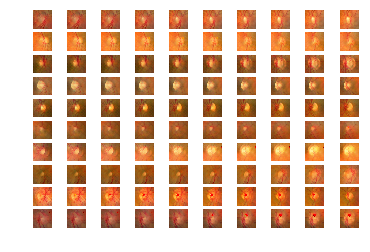

In [51]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
def slerp(val,low,high):
  omega=arccos(clip(dot(low/norm(low),high/norm(high)),-1,1))
  so=sin(omega)
  if so==0:
    return (1.0-val)*low+val*high
  return sin((1.0-val)*omega)/so*low+sin(val*omega)/so*high
def interpolte_points(p1,p2,n_steps=10):
  ratios=linspace(0,1,num=n_steps)
  vectors=list()
  for ratio in ratios:
    v=slerp(ratio,p1,p2)
    vectors.append(v)
  return asarray(vectors)
 
# plot the generated images
def create_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :])
	pyplot.show()
  
  
# load model
model = load_model('generator_model_5.h5')
n=60
# generate images
pts=generate_latent_points(100,n)
results=None
for i in range(0,n,2):
  interpolated=interpolte_points(pts[i],pts[i+1])
  # generate images
  X = model.predict(interpolated)
  # scale from [-1,1] to [0,1]
  X = (X + 1)/2.0 
  if results is None:
    results=X
  else:
    results=vstack((results,X))
  
# plot the result
create_plot(results, 10)
#savem(results,10)

In [0]:
#Download 10 samples of generated image
for i in range(0,10):
  results=X[i]*255
  svimg=Image.fromarray(results.astype('uint8'))
  svimg. save('test{}.png'.format(i))
  files.download('test{}.png'.format(i))
